Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

With mask;
Without mask;
Mask worn incorrectly.

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 398M/398M [00:19<00:00, 21.7MB/s]
100% 398M/398M [00:19<00:00, 21.0MB/s]


In [3]:
# this will extract the all folder in colab
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
annotations_path = "/content/face_mask_detection/annotations"
images_path = "/content/face_mask_detection/images"

In [6]:
import glob
import xml.etree.ElementTree as ET

# Initialize an empty dictionary to store the dataset
dataset = {
    "file": [],
    "name": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
}

# Iterate through XML files in a specified directory
for anno in glob.glob(annotations_path + "/*.xml"):
    # Parse the current XML file
    tree = ET.parse(anno)

    # Loop through all elements in the XML tree
    for elem in tree.iter():
        # Check if the current element is for image size
        if 'size' in elem.tag:
            # Loop through the sub-elements within 'size'
            for attr in list(elem):
                # Extract and store image width and height
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        # Check if the current element is for an object
        if 'object' in elem.tag:
            # Loop through the sub-elements within 'object'
            for attr in list(elem):
                # Extract and store the object name
                if 'name' in attr.tag:
                    name = attr.text
                    dataset['name'] += [name]
                    dataset['width'] += [width]
                    dataset['height'] += [height]
                    # Extract and store the file name (removing the path and extension)
                    dataset['file'] += [anno.split('/')[-1][0:-4]]

                # Check if the current element is for the bounding box
                if 'bndbox' in attr.tag:
                    # Loop through the sub-elements within 'bndbox'
                    for dim in list(attr):
                        # Extract and store bounding box coordinates
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin'] += [ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax'] += [xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax'] += [ymax]

# At this point, the 'dataset' dictionary contains all the extracted data

In [7]:
# create pandas data frame using pandas function
data = pd.DataFrame(dataset)
data

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss478,with_mask,400,400,36,102,157,243
1,maksssksksss478,with_mask,400,400,246,134,362,250
2,maksssksksss602,with_mask,400,226,251,22,270,44
3,maksssksksss567,with_mask,400,267,80,61,116,100
4,maksssksksss567,with_mask,400,267,228,42,260,80
...,...,...,...,...,...,...,...,...
4067,maksssksksss181,with_mask,400,225,100,57,124,82
4068,maksssksksss181,without_mask,400,225,271,43,305,80
4069,maksssksksss693,mask_weared_incorrect,279,400,156,47,183,80
4070,maksssksksss693,with_mask,279,400,90,39,123,72


In [8]:
# now encode the names and create class feature
name_dict = {
    'with_mask':0,
    'without_mask':1,
    'mask_weared_incorrect':2

}

data["class"] = data["name"].map(name_dict)

In [9]:
np.sort(data.name.unique()) #classess

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [10]:
# now split data in to train test
fileNames = [*os.listdir("/content/face_mask_detection/images")]
print(f'There are {len(fileNames)} images in the dataset')

There are 853 images in the dataset


In [11]:
# now do tranin test split
from sklearn.model_selection import train_test_split
train,test = train_test_split(fileNames,test_size=0.1,random_state=42)
print("Length of Train =",len(train))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of test = 86


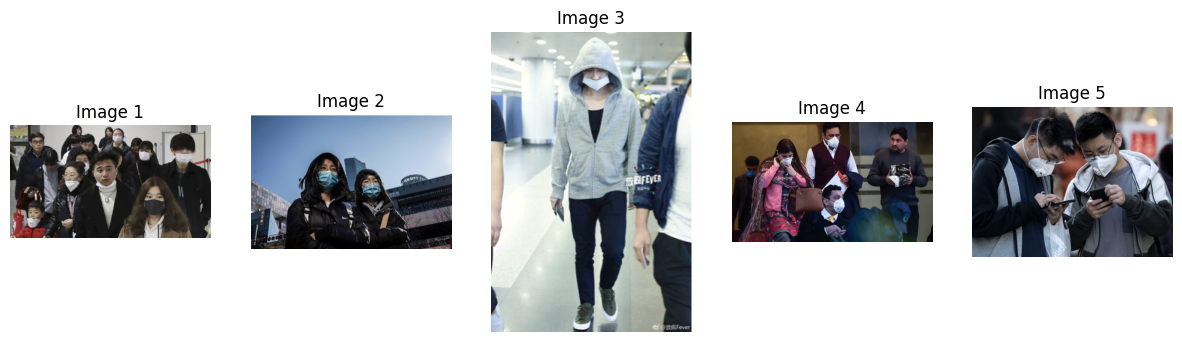

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Directory where your training images are located
data_dir = '/content/face_mask_detection/images'

# List all files in the directory
image_files = os.listdir(data_dir)

# Select 5 random images
random_images = random.sample(image_files, 5)

# Set up a 2x3 grid for displaying the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Loop through and display the selected images
for i, image_file in enumerate(random_images):
    image_path = os.path.join(data_dir, image_file)
    image = imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.show()

In [1]:
!pip install ultralytics # run this command and install yolov8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 9.2 MB/s eta 0:00:00


In [14]:
# create separate train test dir inside
os.mkdir("/content/data/train")
os.mkdir("/content/data/test")
os.mkdir('/content/data/train/images')
os.mkdir('/content/data/train/labels')
os.mkdir('/content/data/test/images')
os.mkdir('/content/data/test/labels')

In [15]:
input_data = '/content/face_mask_detection'
output_data = '/content'

In [16]:
from PIL import Image  # Make sure to import the required module

# Define a function to copy and resize images
def copyImages(imageList, folder_Name):
    for image in imageList:
        # Open the image using PIL (Pillow) from the input_data/images directory
        img = Image.open(input_data + "/images/" + image)

        # Resize the image to a width of 640 pixels and a height of 480 pixels
        img1 = img.resize((640, 480))

        # Save the resized image to the output_datafolder_Name/images directory
        # The 'folder_Name' is provided as an argument to the function
        _ = img1.save(output_data + "/data/" + folder_Name + "/images/" + image)

# Call the function for different sets of images (train, val, test)
copyImages(train, "train")  # Copy and resize images for the 'train' set
copyImages(test, "test")    # Copy and resize images for the 'test' set

In [17]:
# Scale the 'xmax' values based on the width of 640 pixels and the original 'width' values
data['xmax'] = (640 / data['width']) * data['xmax']

# Scale the 'ymax' values based on the height of 480 pixels and the original 'height' values
data['ymax'] = (480 / data['height']) * data['ymax']

# Scale the 'xmin' values based on the width of 640 pixels and the original 'width' values
data['xmin'] = (640 / data['width']) * data['xmin']

# Scale the 'ymin' values based on the height of 480 pixels and the original 'height' values
data['ymin'] = (480 / data['height']) * data['ymin']

In [18]:
# Convert the 'xmax', 'ymax', 'xmin', and 'ymin' columns to integer data type (int64)
data[['xmax', 'ymax', 'xmin', 'ymin']] = data[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [19]:
# Calculate the x-center of bounding boxes, normalized by the image width (640 pixels)
data['x_center'] = (data['xmax'] + data['xmin']) / (2 * 640)

# Calculate the y-center of bounding boxes, normalized by the image height (480 pixels)
data['y_center'] = (data['ymax'] + data['ymin']) / (2 * 480)

# Calculate the height of bounding boxes, normalized by the image width (640 pixels)
data['box_height'] = (data['xmax'] - data['xmin']) / 640

# Calculate the width of bounding boxes, normalized by the image height (480 pixels)
data['box_width'] = (data['ymax'] - data['ymin']) / 480

In [20]:
data


,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss478,with_mask,400,400,57,122,251,291,0,0.240625,0.430208,0.303125,0.352083
1,maksssksksss478,with_mask,400,400,393,160,579,300,0,0.759375,0.479167,0.290625,0.291667
2,maksssksksss602,with_mask,400,226,401,46,432,93,0,0.650781,0.144792,0.048438,0.097917
3,maksssksksss567,with_mask,400,267,128,109,185,179,0,0.244531,0.300000,0.089063,0.145833
4,maksssksksss567,with_mask,400,267,364,75,416,143,0,0.609375,0.227083,0.081250,0.141667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss181,with_mask,400,225,160,121,198,174,0,0.279687,0.307292,0.059375,0.110417
4068,maksssksksss181,without_mask,400,225,433,91,488,170,1,0.719531,0.271875,0.085938,0.164583
4069,maksssksksss693,mask_weared_incorrect,279,400,357,56,419,96,2,0.606250,0.158333,0.096875,0.083333
4070,maksssksksss693,with_mask,279,400,206,46,282,86,0,0.381250,0.137500,0.118750,0.083333


In [21]:
# convert in to string
data = data.astype("string")

In [22]:
# Define a function to create label files for YOLO format
def create_labels(image_list, data_name):
    # Extract file names by removing the file extensions
    fileNames = [x.split(".")[0] for x in image_list]

    # Iterate through each image file name
    for name in fileNames:
        # Filter the DataFrame to get data related to the current image
        data_ = data[data.file == name]
        box_list = []  # Initialize a list to store bounding box information

        # Iterate through rows in the filtered data
        for index in range(len(data_)):
            row = data_.iloc[index]

            # Construct a string with YOLO format: class x_center y_center box_height box_width
            box_list.append(
                row['class'] + " " + str(row["x_center"]) + " " + str(row["y_center"]) +
                " " + str(row["box_height"]) + " " + str(row["box_width"])
            )

        # Join the bounding box strings and create a label file for the image
        text = "\n".join(box_list)
        with open(output_data + "/data/" + data_name + "/labels/" + name + ".txt", "w") as file:
            file.write(text)

# Create label files for the 'train', 'val', and 'test' sets
create_labels(train, "train")  # Create labels for the 'train' set
create_labels(test, "test")    # Create labels for the 'test' set

In [32]:
%cat /content/data.yaml

train: /content/data/train/images
val: /content/data/test/images

nc: 3

names: ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [59]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/107.7 GB disk)


In [63]:
from ultralytics import YOLO
from IPython.display import display,Image

In [33]:
# Train YOLOv8 on your custom data use this comand
!yolo task=detect mode=train model=yolov8s.pt data= data.yaml epochs=101 imgsz=416 plots=True

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=101, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int

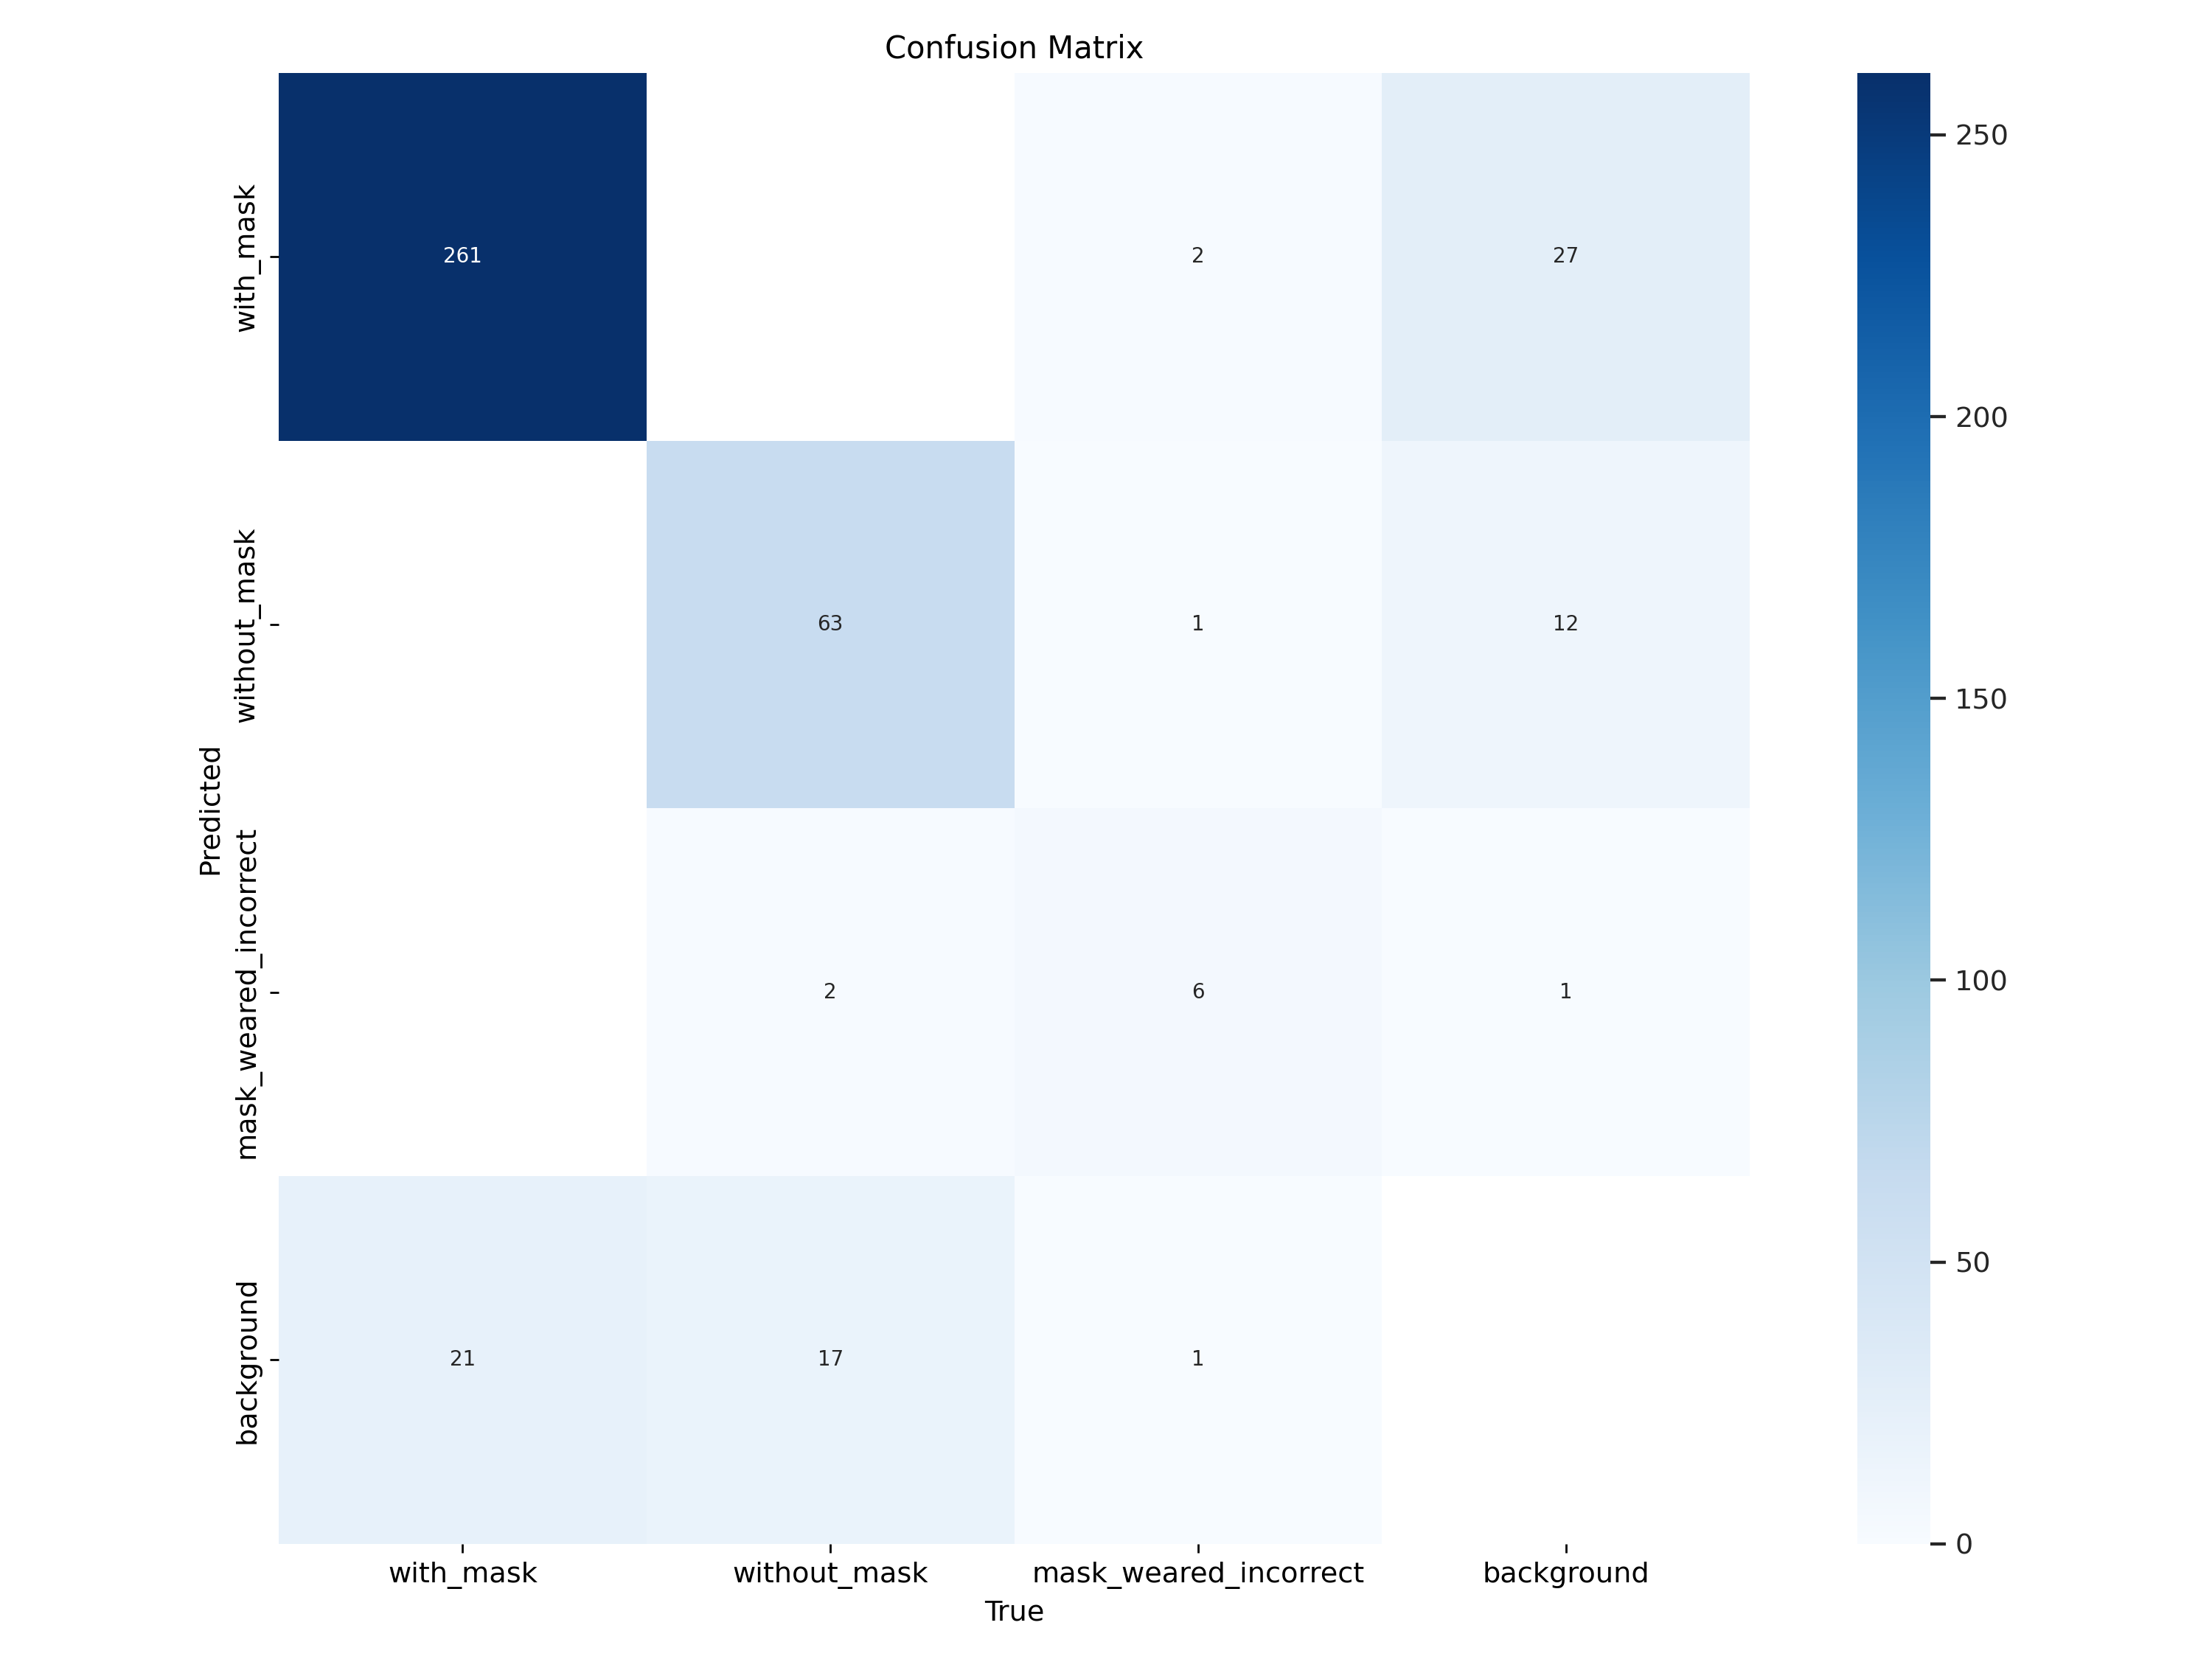

In [34]:
Image(filename="/content/runs/detect/train2/confusion_matrix.png",width=600)

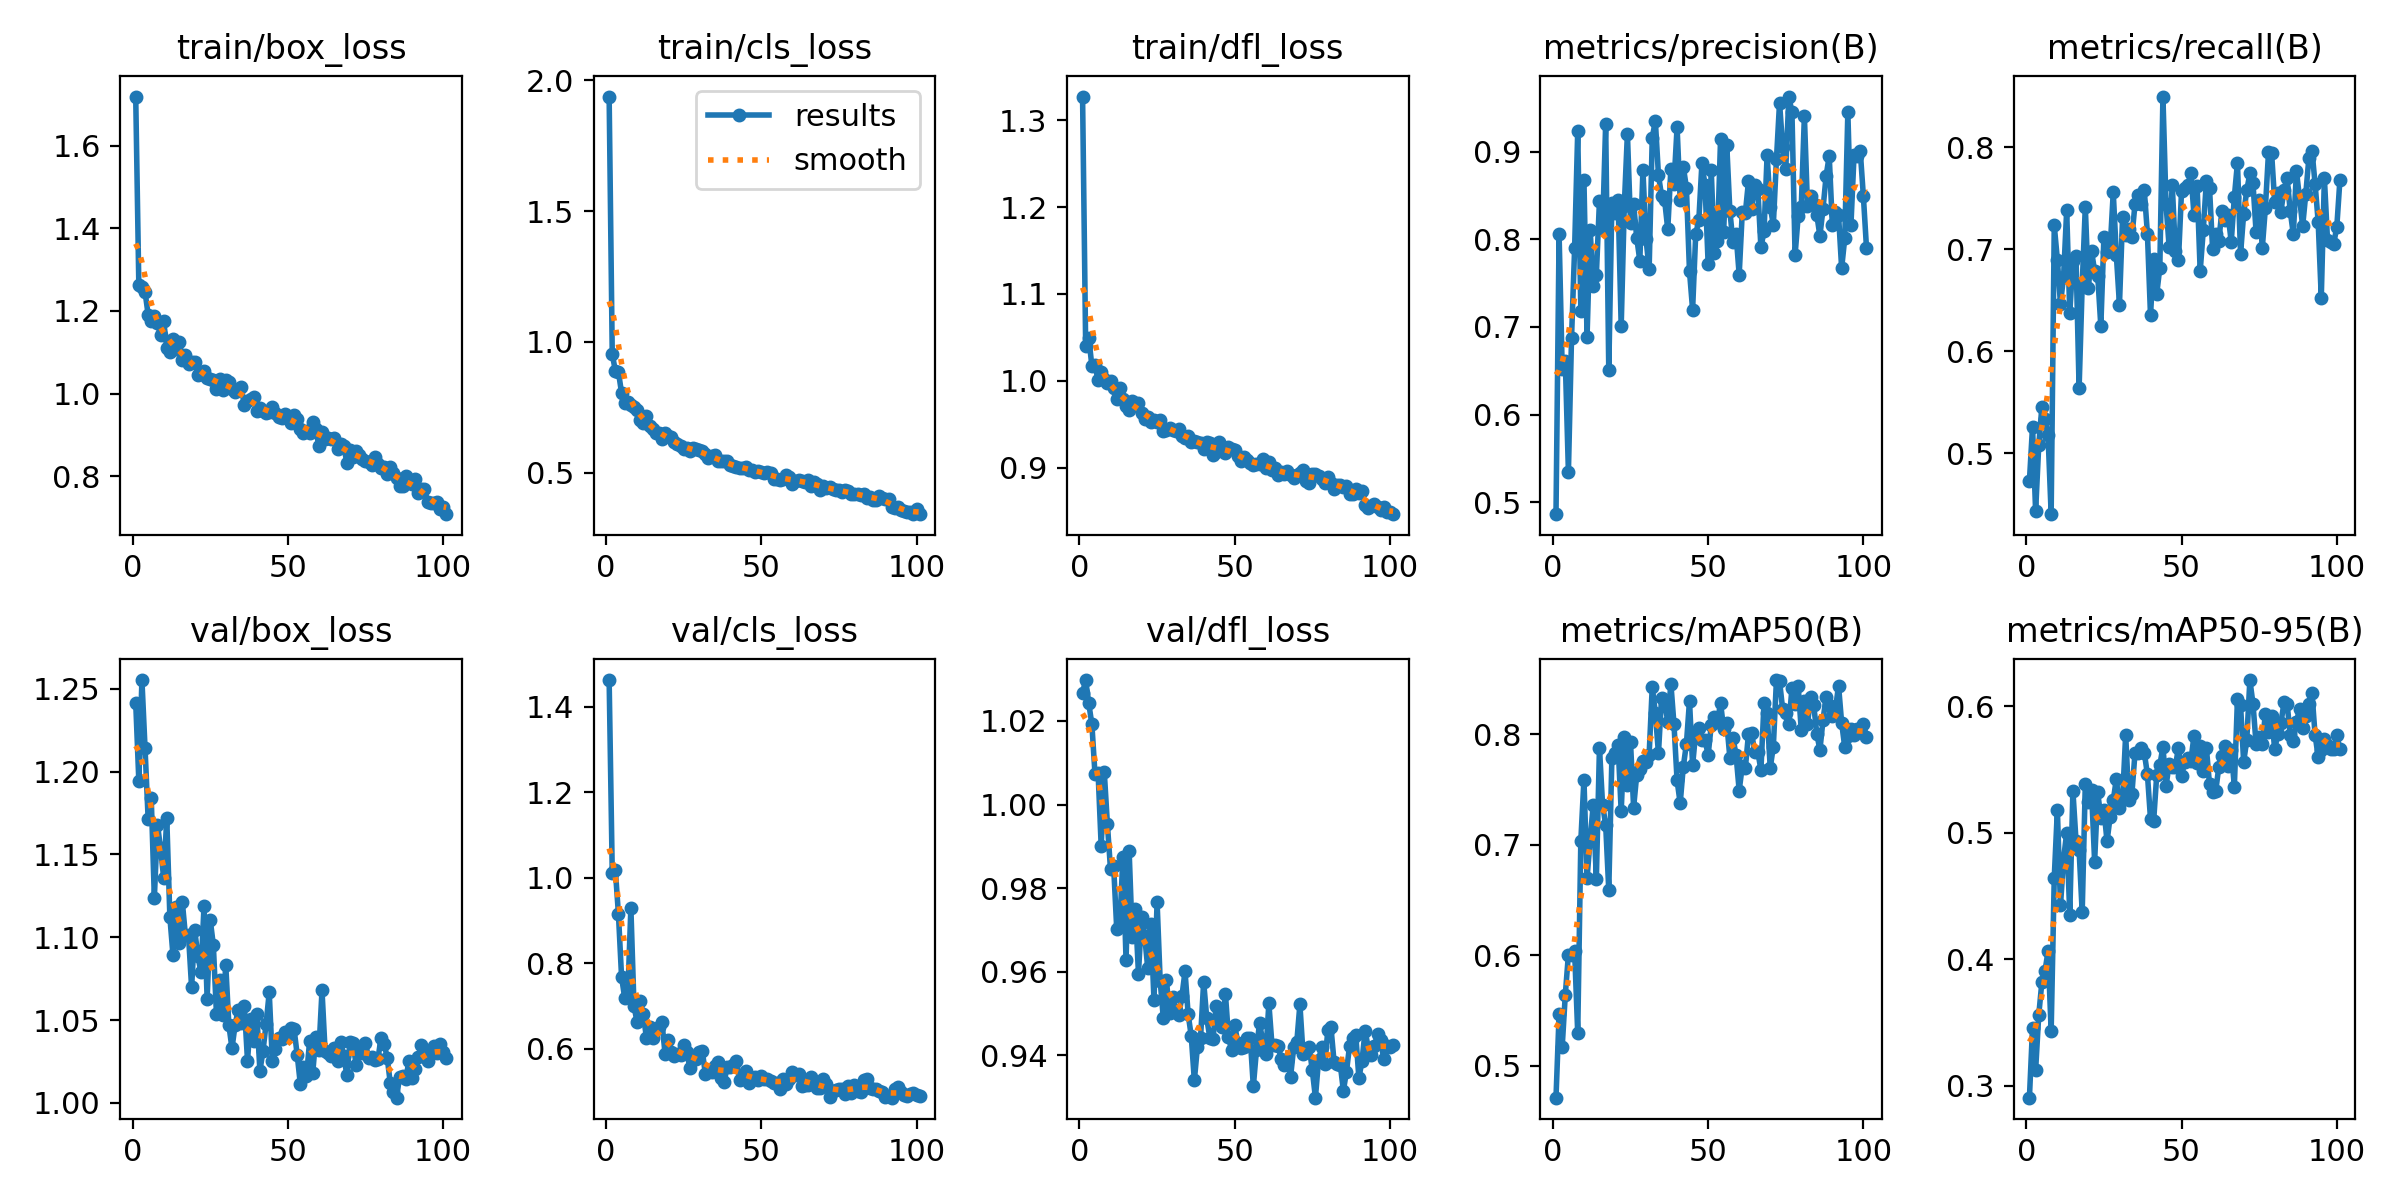

In [35]:
Image(filename="/content/runs/detect/train2/results.png",width=600)

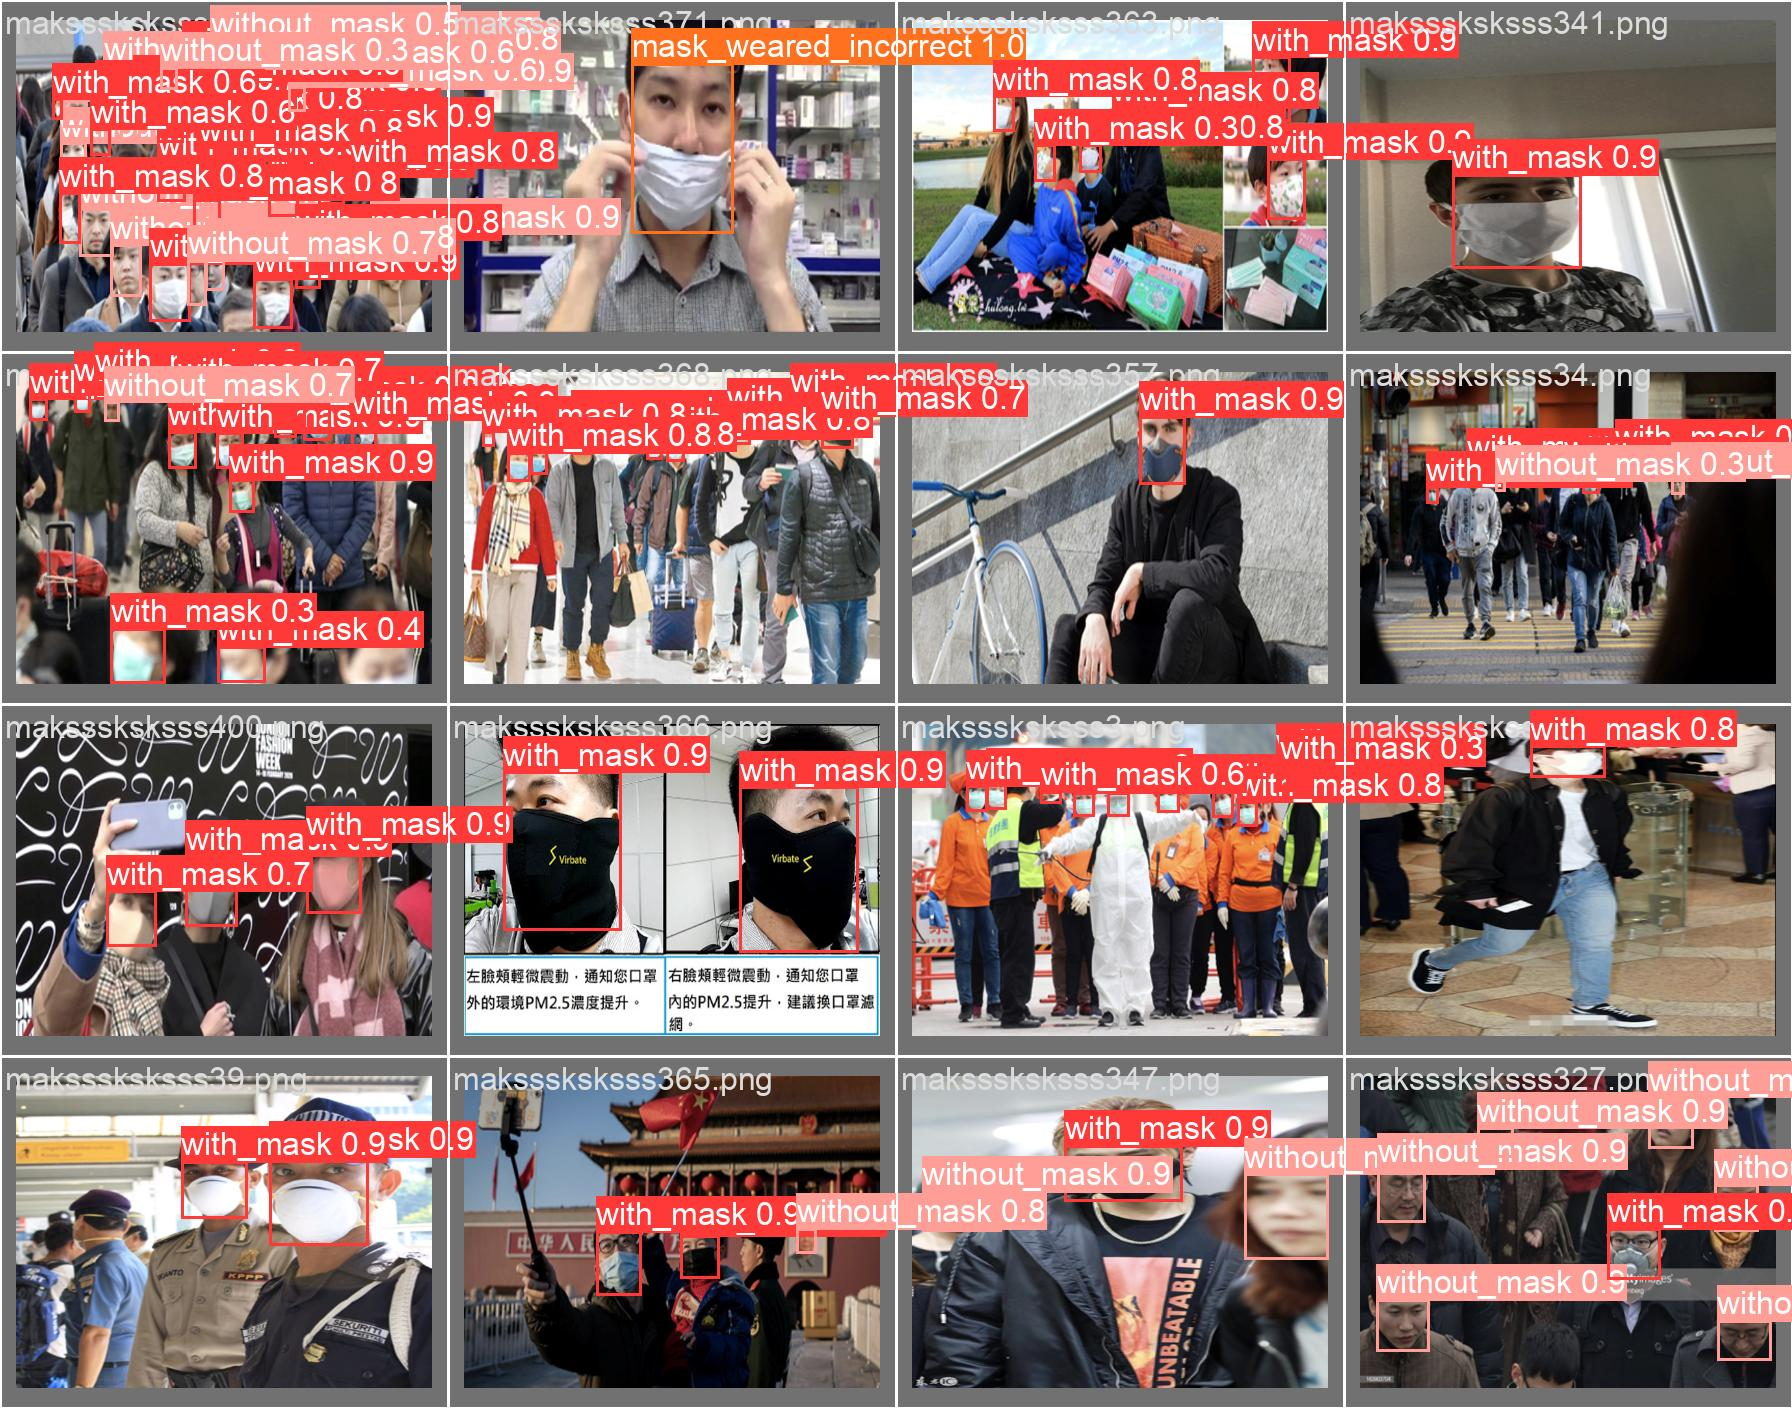

In [38]:
#prediction batchs of yolov8
Image(filename="/content/runs/detect/train2/val_batch2_pred.jpg",width=600)

In [40]:
# now validate model
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt data= data.yaml

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/data/test/labels.cache... 86 images, 0 backgrounds, 0 corrupt: 100% 86/86 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:05<00:00,  1.19it/s]
                   all         86        374      0.893      0.775      0.849      0.621
             with_mask         86        282      0.932      0.904      0.949      0.701
          without_mask         86         82      0.901       0.72      0.856       0.59
 mask_weared_incorrect         86         10      0.845        0.7      0.742      0.571
Speed: 2.0ms preprocess, 11.9ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [41]:
# Inference on the test data and predict
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt data= data.yaml conf=0.50 source=/content/data/test/images

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

image 1/86 /content/data/test/images/maksssksksss115.png: 320x416 9 with_masks, 200.2ms
image 2/86 /content/data/test/images/maksssksksss129.png: 320x416 1 with_mask, 2 without_masks, 11.7ms
image 3/86 /content/data/test/images/maksssksksss131.png: 320x416 4 with_masks, 3 without_masks, 8.8ms
image 4/86 /content/data/test/images/maksssksksss136.png: 320x416 1 with_mask, 8.8ms
image 5/86 /content/data/test/images/maksssksksss141.png: 320x416 2 with_masks, 9.5ms
image 6/86 /content/data/test/images/maksssksksss153.png: 320x416 1 without_mask, 10.6ms
image 7/86 /content/data/test/images/maksssksksss169.png: 320x416 1 with_mask, 10.6ms
image 8/86 /content/data/test/images/maksssksksss189.png: 320x416 1 with_mask, 1 without_mask, 10.1ms
image 9/86 /content/data/test/images/maksssksksss192.png: 320x416 1 with_mask, 8.3ms
ima

In [70]:
!yolo task=detect mode=predict model=/content/best.pt data= data.yaml conf=0.50 source=/content/918a839116b1bdd325d6f8180718be73.jpeg

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/918a839116b1bdd325d6f8180718be73.jpeg: 320x416 19 with_masks, 12 without_masks, 1 mask_weared_incorrect, 284.3ms
Speed: 2.3ms preprocess, 284.3ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 416)
Results saved to runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict


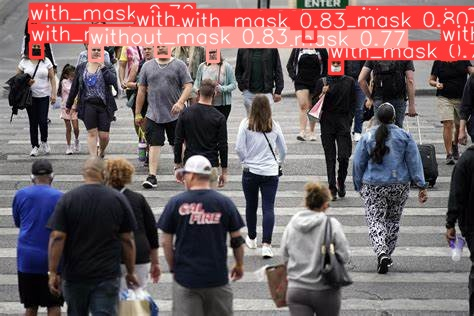

In [64]:
# from PIL import Image
#prediction  of yolov8
Image(filename="/content/runs/detect/predict/OIP.jpeg",width=600)

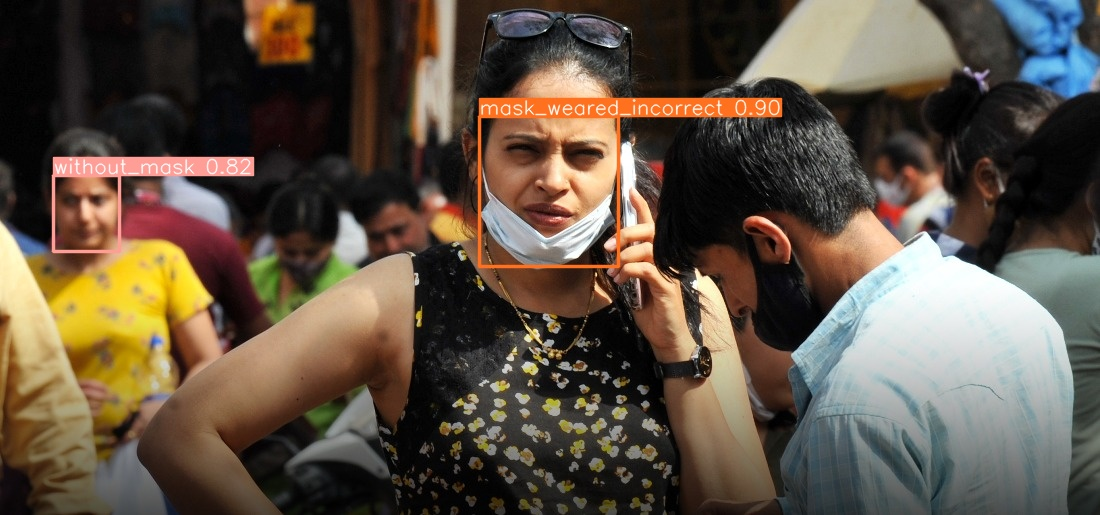

In [65]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict2/without-mask-wearing_60d46c60aae23.jpg",width=600)

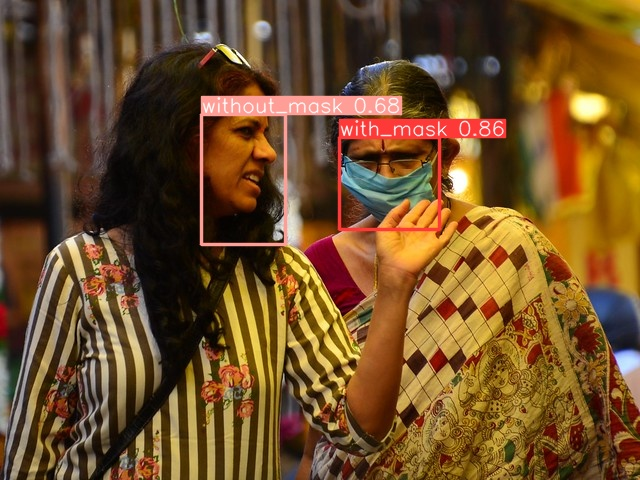

In [66]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict3/52625345303_69a0e6784e_z.jpg",width=600)

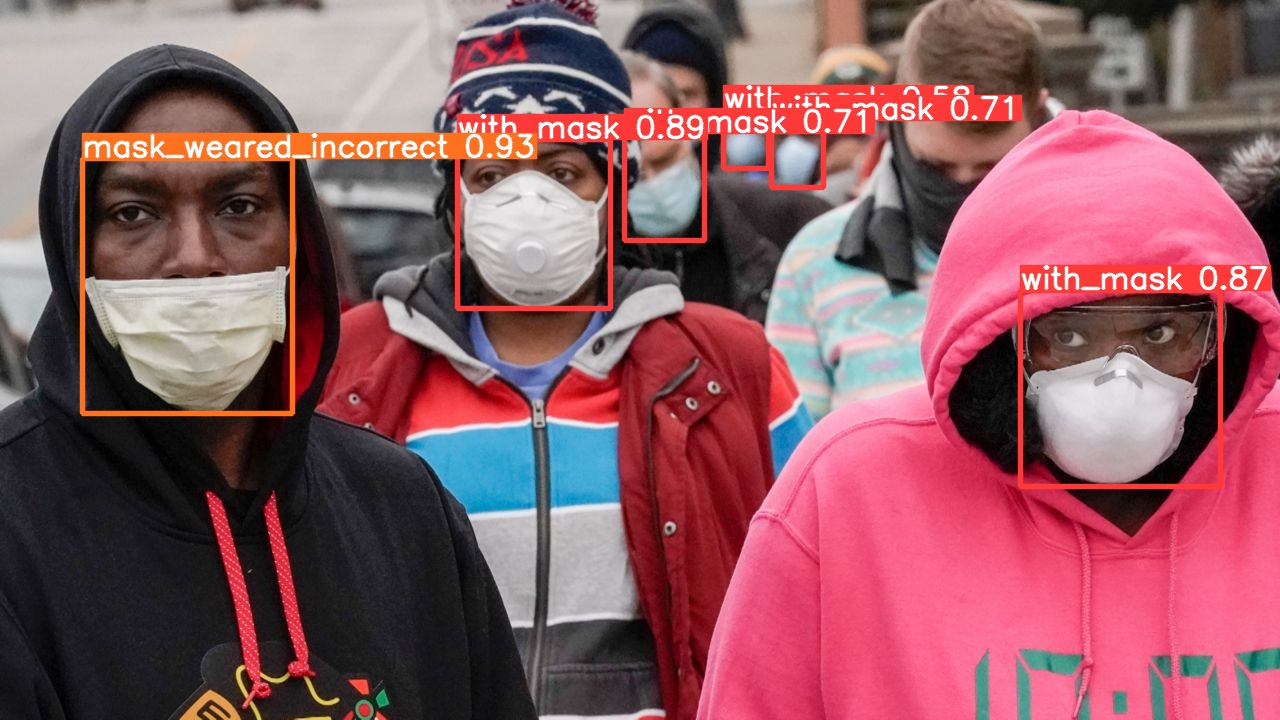

In [67]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict4/MASK_1.jpeg",width=600)

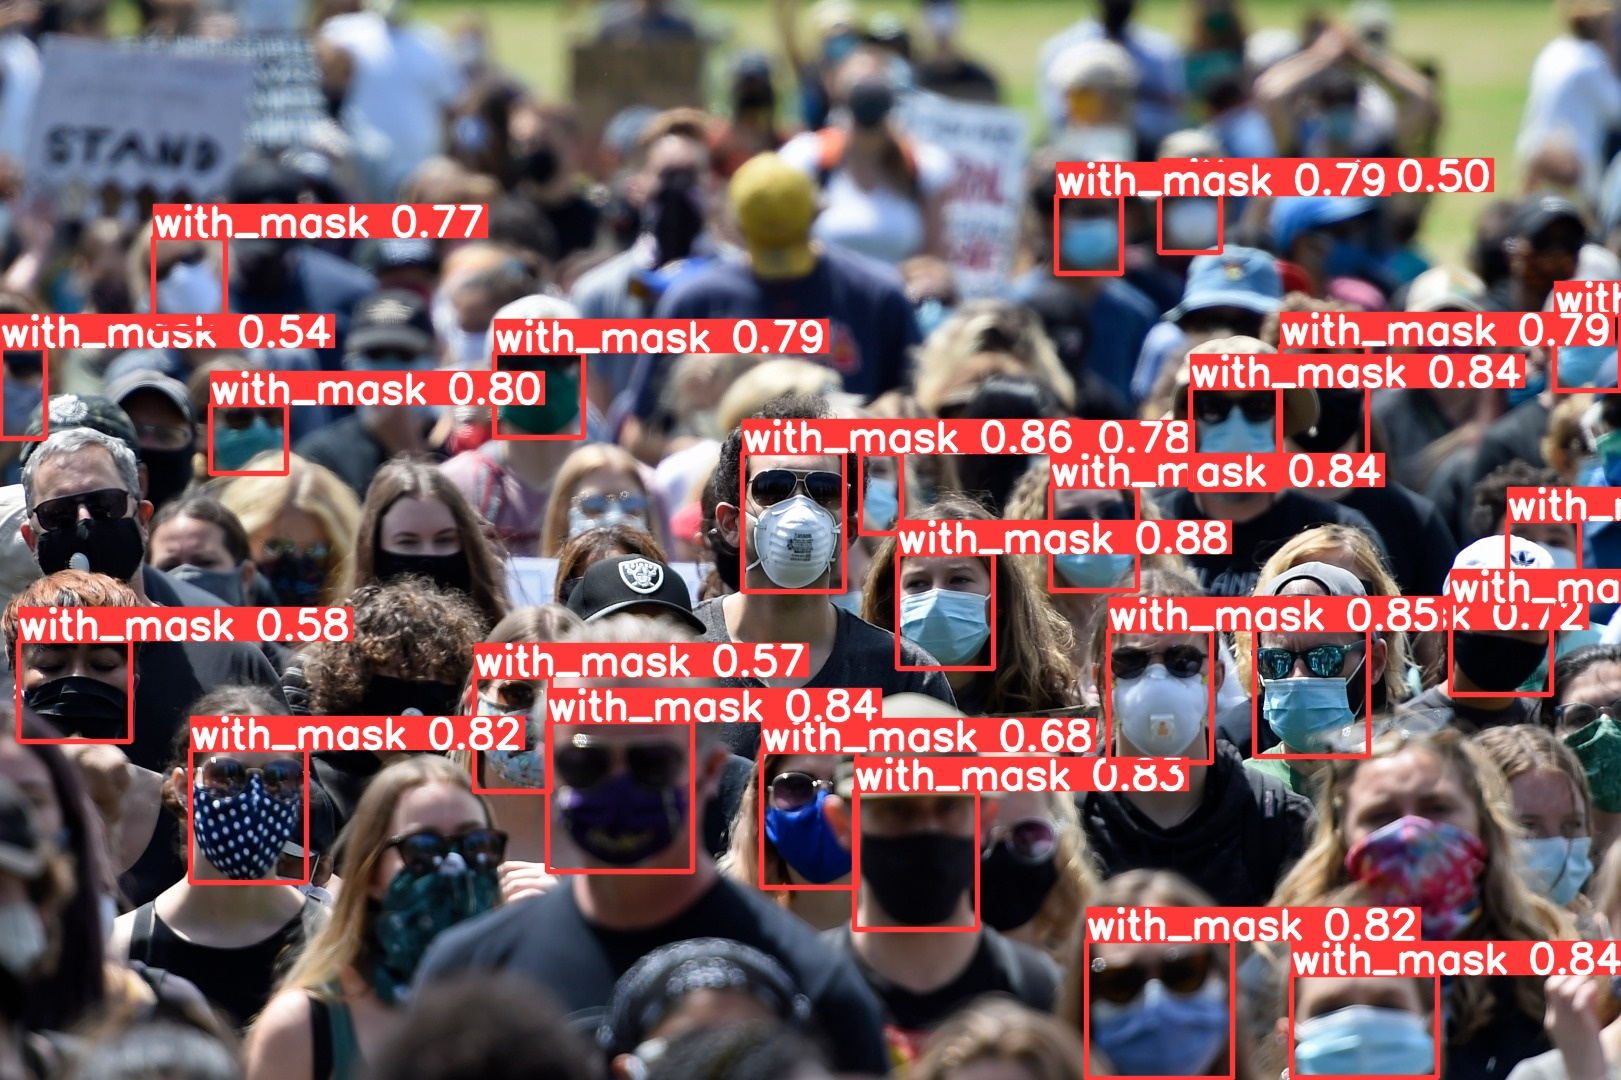

In [69]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict5/R.jpeg",width=600)

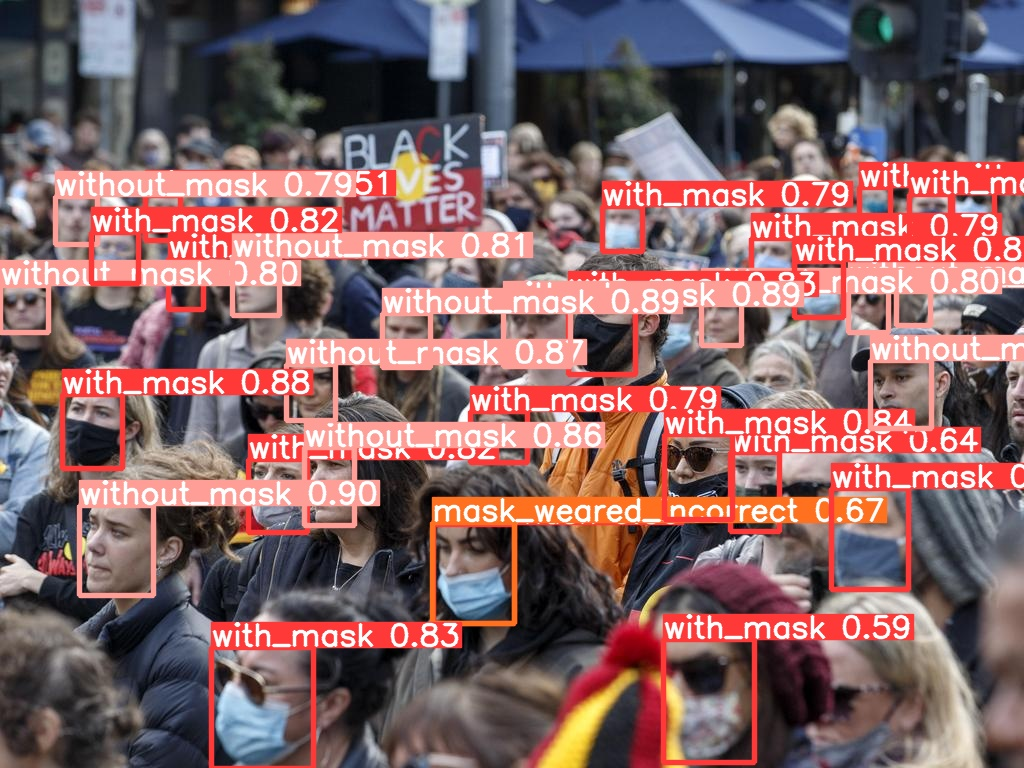

In [71]:
#prediction  of yolov8
Image(filename="/content/runs/detect/predict6/918a839116b1bdd325d6f8180718be73.jpeg",width=600)